# Humpback Whale Identification - CNN with Keras
This kernel is based on [Anezka Kolaceke](https://www.kaggle.com/anezka)'s awesome work: [CNN with Keras for Humpback Whale ID](https://www.kaggle.com/anezka/cnn-with-keras-for-humpback-whale-id)

In [1]:
import numpy as np 
import pandas as pd 
import os
import matplotlib.pyplot as plt
import matplotlib.image as mplimg
from matplotlib.pyplot import imshow
import gc

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

from keras import layers
from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input
from keras.layers import Input, Dense, Activation, BatchNormalization, Flatten, Conv2D
from keras.layers import AveragePooling2D, MaxPooling2D, Dropout
from keras.models import Model

import keras.backend as K
from keras.models import Sequential

import warnings
warnings.simplefilter("ignore", category=DeprecationWarning)

Using TensorFlow backend.


In [ ]:
#os.listdir("data/input")

In [2]:
# importing the training data
train_df = pd.read_csv("data/train.csv")
train_df.head()

,Image,Id
0,0000e88ab.jpg,w_f48451c
1,0001f9222.jpg,w_c3d896a
2,00029d126.jpg,w_20df2c5
3,00050a15a.jpg,new_whale
4,0005c1ef8.jpg,new_whale


In [3]:
# this will show the amount of images in some of the categories
train_df.Id.value_counts().head()

new_whale    9664
w_23a388d      73
w_9b5109b      65
w_9c506f6      62
w_0369a5c      61
Name: Id, dtype: int64

In [4]:
# now the new_whale data points will be removed from the dataframe
I_dont_want_new_whales = train_df['Id'] != 'new_whale'
train_df = train_df[I_dont_want_new_whales]
train_df.Id.value_counts().head()

w_23a388d    73
w_9b5109b    65
w_9c506f6    62
w_0369a5c    61
w_700ebb4    57
Name: Id, dtype: int64

In [5]:
# this will be used to preprocess the datasets
def prepareImages(data, m, dataset):
    print("Preparing images")
    X_train = np.zeros((m, 100, 100, 3))
    count = 0
    
    for fig in data['Image']:
        #load images into images of size 100x100x3
        img = image.load_img("data/"+dataset+"/"+fig, target_size=(100, 100, 3))
        x = image.img_to_array(img)
        x = preprocess_input(x)

        X_train[count] = x
        if (count%500 == 0):
            print("Processing image: ", count+1, ", ", fig)
        count += 1
    
    return X_train

In [9]:
# this will be used to generate labels for the training set
def prepare_labels(y):
    values = np.array(y)
    label_encoder = LabelEncoder()
    integer_encoded = label_encoder.fit_transform(values)
    # print(integer_encoded)

    onehot_encoder = OneHotEncoder(sparse=False)
    integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
    onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
    # print(onehot_encoded)#

    y = onehot_encoded
    # print(y.shape)
    return y, label_encoder

In [10]:
# This chunk of code was added to resolve the error "OSError: image file is truncated" in the below cell
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [11]:
# now the training data will be imported
X = prepareImages(train_df, train_df.shape[0], "train")
X /= 255

Preparing images
Processing image:  1 ,  0000e88ab.jpg
Processing image:  501 ,  0823f9df3.jpg
Processing image:  1001 ,  10b694367.jpg
Processing image:  1501 ,  195805c52.jpg
Processing image:  2001 ,  21e28ae02.jpg
Processing image:  2501 ,  2a1146baa.jpg
Processing image:  3001 ,  32533a7fb.jpg
Processing image:  3501 ,  3a8173905.jpg
Processing image:  4001 ,  42f134dea.jpg
Processing image:  4501 ,  4aa4de13a.jpg
Processing image:  5001 ,  5297b6c40.jpg
Processing image:  5501 ,  5b7f0e6e6.jpg
Processing image:  6001 ,  6311688b7.jpg
Processing image:  6501 ,  6b29760e3.jpg
Processing image:  7001 ,  7390cbfab.jpg
Processing image:  7501 ,  7b949f512.jpg
Processing image:  8001 ,  83336c385.jpg
Processing image:  8501 ,  8b369569b.jpg
Processing image:  9001 ,  92f450203.jpg
Processing image:  9501 ,  9b984102a.jpg
Processing image:  10001 ,  a39babc55.jpg
Processing image:  10501 ,  ab6f8bddd.jpg
Processing image:  11001 ,  b36da6f7c.jpg
Processing image:  11501 ,  bb9ffa8b2.jpg

In [12]:
y, label_encoder = prepare_labels(train_df['Id'])

/home/ndurai2006/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:368: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [13]:
y.shape

(15697, 5004)

In [14]:
# the CNN will now be defined
model = Sequential()

model.add(Conv2D(32, (7, 7), strides = (1, 1), name = 'conv0', input_shape = (100, 100, 3)))

model.add(BatchNormalization(axis = 3, name = 'bn0'))
model.add(Activation('relu'))

model.add(MaxPooling2D((2, 2), name='max_pool'))
model.add(Conv2D(64, (3, 3), strides = (1,1), name="conv1"))
model.add(Activation('relu'))
model.add(AveragePooling2D((3, 3), name='avg_pool'))

model.add(Flatten())
model.add(Dense(500, activation="relu", name='rl'))
model.add(Dropout(0.8))
model.add(Dense(y.shape[1], activation='softmax', name='sm'))

model.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv0 (Conv2D)               (None, 94, 94, 32)        4736      
_________________________________________________________________
bn0 (BatchNormalization)     (None, 94, 94, 32)        128       
_________________________________________________________________
activation_1 (Activation)    (None, 94, 94, 32)        0         
_________________________________________________________________
max_pool (MaxPooling2D)      (None, 47, 47, 32)        0         
_________________________________________________________________
conv1 (Conv2D)               (None, 45, 45, 64)        18496     
_________________________________________________________________
activation_2 (Activation)    (None, 45, 45, 64)        0         
_________________________________________________________________
avg_pool (AveragePooling2D)  (None, 15, 15, 64)        0         
__________

In [15]:
# this will train the CNN
history = model.fit(X, y, epochs=100, batch_size=100, verbose=1)
gc.collect()

Epoch 1/100
15697/15697 [==============================] - 835s 53ms/step - loss: 8.4461 - acc: 0.0036
Epoch 2/100
15697/15697 [==============================] - 832s 53ms/step - loss: 8.1655 - acc: 0.0039
Epoch 3/100
15697/15697 [==============================] - 832s 53ms/step - loss: 8.0699 - acc: 0.0043
Epoch 4/100
15697/15697 [==============================] - 832s 53ms/step - loss: 7.9804 - acc: 0.0076
Epoch 5/100
15697/15697 [==============================] - 834s 53ms/step - loss: 7.8581 - acc: 0.0113
Epoch 6/100
15697/15697 [==============================] - 832s 53ms/step - loss: 7.7150 - acc: 0.0143
Epoch 7/100
15697/15697 [==============================] - 833s 53ms/step - loss: 7.5666 - acc: 0.0155
Epoch 8/100
15697/15697 [==============================] - 831s 53ms/step - loss: 7.4100 - acc: 0.0192
Epoch 9/100
15697/15697 [==============================] - 833s 53ms/step - loss: 7.2337 - acc: 0.0234
Epoch 10/100
15697/15697 [==============================] - 832s 53ms/ste

15697/15697 [==============================] - 844s 54ms/step - loss: 0.7360 - acc: 0.8063
Epoch 80/100
15697/15697 [==============================] - 846s 54ms/step - loss: 0.7230 - acc: 0.8074
Epoch 81/100
15697/15697 [==============================] - 844s 54ms/step - loss: 0.7306 - acc: 0.8051
Epoch 82/100
15697/15697 [==============================] - 843s 54ms/step - loss: 0.7157 - acc: 0.8073
Epoch 83/100
15697/15697 [==============================] - 842s 54ms/step - loss: 0.7225 - acc: 0.8101
Epoch 84/100
15697/15697 [==============================] - 844s 54ms/step - loss: 0.7183 - acc: 0.8075
Epoch 85/100
15697/15697 [==============================] - 843s 54ms/step - loss: 0.6766 - acc: 0.8191
Epoch 86/100
15697/15697 [==============================] - 846s 54ms/step - loss: 0.6740 - acc: 0.8209
Epoch 87/100
15697/15697 [==============================] - 844s 54ms/step - loss: 0.6654 - acc: 0.8206
Epoch 88/100
15697/15697 [==============================] - 845s 54ms/step - 

9240

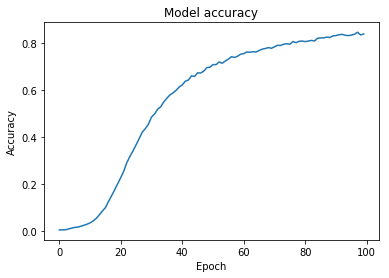

In [16]:
# This will plot the accuracy of the CNN on the training set after each epoch
plt.plot(history.history['acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.show()

In [17]:
# Now an optimal threshold for the new_whale label will be determined.
# First the entire training set (includeing new_whales) will be imported
train_df = pd.read_csv("data/train.csv")
X = prepareImages(train_df, train_df.shape[0], "train")
X /= 255
y = train_df['Id']

Preparing images
Processing image:  1 ,  0000e88ab.jpg
Processing image:  501 ,  04c72257b.jpg
Processing image:  1001 ,  09cacb84d.jpg
Processing image:  1501 ,  0ef961892.jpg
Processing image:  2001 ,  141b56a1a.jpg
Processing image:  2501 ,  199a417aa.jpg
Processing image:  3001 ,  1ec170983.jpg
Processing image:  3501 ,  23f084b93.jpg
Processing image:  4001 ,  29163ad0b.jpg
Processing image:  4501 ,  2e0fab120.jpg
Processing image:  5001 ,  3347515d9.jpg
Processing image:  5501 ,  3842d71dc.jpg
Processing image:  6001 ,  3d7f4c7d5.jpg
Processing image:  6501 ,  425f763ca.jpg
Processing image:  7001 ,  4714400cd.jpg
Processing image:  7501 ,  4c082fbdf.jpg
Processing image:  8001 ,  50c683e23.jpg
Processing image:  8501 ,  560d986ad.jpg
Processing image:  9001 ,  5b68c83ed.jpg
Processing image:  9501 ,  60410f111.jpg
Processing image:  10001 ,  654951f81.jpg
Processing image:  10501 ,  6a572256c.jpg
Processing image:  11001 ,  6f96f55b6.jpg
Processing image:  11501 ,  74da2b511.jpg

In [18]:
# the map5 function will be used to evaluate the predictions
def map5(X, y):
    score = 0
    for i in range(X.shape[0]):
        pred = X[i]
        lp = label_encoder.inverse_transform(pred.argsort()[-5:][::-1])
        p2 = pred[:]
        ind = pred.argsort()[-5:][::-1]
        s = sum(p2[ind] < th)
        if s != 0:
            for j in range(lp.size):
                if p2[ind[j]] < th:
                    k = j
                    lp[k] = 'new_whale'
                    break
# the below line is commented to avoid the error "UnboundLocalError: local variable 'k' referenced before assignment"
#            lp[k] = 'new_whale'
        #pred = X[i].argsort()[-5:][::-1]
        for j in range(lp.size):
            if lp[j] == y[i]:
                score += (5 - j)/5
                break
    return score/X.shape[0]

# now the optimal threshold will be determined by calculating the map5 score for each threshold value.
predictions = model.predict(np.array(X), verbose=1)
best_th = 0
best_score = 0
for th in np.arange(0.1, 0.91, 0.01):
    #predictions[:,0] = th
    score = map5(predictions, y)
    if score > best_score:
        best_score = score
        best_th = th
    print("Threshold = {:.3f}, MAP5 = {:.3f}".format(th,score))

25361/25361 [==============================] - 561s 22ms/step
Threshold = 0.100, MAP5 = 0.842
Threshold = 0.110, MAP5 = 0.853
Threshold = 0.120, MAP5 = 0.862
Threshold = 0.130, MAP5 = 0.870
Threshold = 0.140, MAP5 = 0.877
Threshold = 0.150, MAP5 = 0.883
Threshold = 0.160, MAP5 = 0.888
Threshold = 0.170, MAP5 = 0.893
Threshold = 0.180, MAP5 = 0.898
Threshold = 0.190, MAP5 = 0.902
Threshold = 0.200, MAP5 = 0.906
Threshold = 0.210, MAP5 = 0.910
Threshold = 0.220, MAP5 = 0.913
Threshold = 0.230, MAP5 = 0.916
Threshold = 0.240, MAP5 = 0.919
Threshold = 0.250, MAP5 = 0.923
Threshold = 0.260, MAP5 = 0.925
Threshold = 0.270, MAP5 = 0.928
Threshold = 0.280, MAP5 = 0.930
Threshold = 0.290, MAP5 = 0.932
Threshold = 0.300, MAP5 = 0.934
Threshold = 0.310, MAP5 = 0.936
Threshold = 0.320, MAP5 = 0.938
Threshold = 0.330, MAP5 = 0.940
Threshold = 0.340, MAP5 = 0.941
Threshold = 0.350, MAP5 = 0.943
Threshold = 0.360, MAP5 = 0.945
Threshold = 0.370, MAP5 = 0.946
Threshold = 0.380, MAP5 = 0.948
Threshold 

In [19]:
# now the predictions for the test data can be made
test = os.listdir("data/test")
print(len(test))

7960


In [20]:
# a new column that will contain the five predictions will be made
col = ['Image']
test_df = pd.DataFrame(test, columns=col)
test_df['Id'] = ''

In [21]:
# this will preprocess the test data
X = prepareImages(test_df, test_df.shape[0], "test")
X /= 255

Preparing images
Processing image:  1 ,  bfd521ee0.jpg
Processing image:  501 ,  f124e20f9.jpg
Processing image:  1001 ,  7fd675d90.jpg
Processing image:  1501 ,  f15cc97a7.jpg
Processing image:  2001 ,  b0ced16b2.jpg
Processing image:  2501 ,  5b8f3af0a.jpg
Processing image:  3001 ,  00ccb53ec.jpg
Processing image:  3501 ,  378f63826.jpg
Processing image:  4001 ,  a8e72eb20.jpg
Processing image:  4501 ,  599fb6ecf.jpg
Processing image:  5001 ,  292b2b27d.jpg
Processing image:  5501 ,  2aeee8b9f.jpg
Processing image:  6001 ,  ea046b98d.jpg
Processing image:  6501 ,  43e35c1b6.jpg
Processing image:  7001 ,  e67b3fc69.jpg
Processing image:  7501 ,  bc605917b.jpg


In [22]:
# now the labels for the test data will be generated
predictions = model.predict(np.array(X), verbose=1)

7960/7960 [==============================] - 174s 22ms/step


In [23]:
# best_th = 0.01 # only run this line if you did not determine the optimal threshold

for i, pred in enumerate(predictions):
    lp = label_encoder.inverse_transform(pred.argsort()[-5:][::-1])
    p2 = pred[:]
    ind = pred.argsort()[-5:][::-1]
    s = sum(p2[ind] < best_th)
    if s != 0:
        for j in range(lp.size):
            if p2[ind[j]] < best_th:
                k = j
                lp[k] = 'new_whale'
                break
#        lp[k] = 'new_whale'
    test_df.loc[i, 'Id'] = ' '.join(lp)

In [24]:
# now the predictions will be saved in a csv file which can be submitted
print(test_df.head(10))
test_df.to_csv("data/submission_v5.csv", index=False)

           Image                                                 Id
0  bfd521ee0.jpg  new_whale w_f6c5343 w_564a34b w_59052ad w_f829227
1  02b063a20.jpg  new_whale w_9ba4a9a w_700ebb4 w_cd4cb49 w_53215c6
2  48dc51d2a.jpg  new_whale w_89f6097 w_23a388d w_1f0cf0a w_a9304b9
3  f553318b3.jpg  new_whale w_a586dce w_3bf2653 w_f765256 w_eba33fb
4  1546729ec.jpg  new_whale w_700ebb4 w_67153b4 w_f765256 w_51fc1fc
5  8cc48ab02.jpg  new_whale w_23a388d w_c25d2d1 w_cb4182e w_6cda039
6  de74478c6.jpg  new_whale w_a9304b9 w_53215c6 w_9b5109b w_4a28f21
7  211d8987b.jpg  new_whale w_16df050 w_700ebb4 w_a9304b9 w_0369a5c
8  b0675b37a.jpg  new_whale w_0369a5c w_343f088 w_aa32f70 w_9b5109b
9  8c10e784e.jpg  new_whale w_cd4cb49 w_d405854 w_0369a5c w_8193215


In [ ]:
########## IGNORE THE REMAINING CODE BLOCKS!!!! #############

In [ ]:
#train_df = pd.read_csv("data/train.csv")
#X = prepareImages(train_df, train_df.shape[0], "train")
#X /= 255
#y, label_encoder = prepare_labels(train_df['Id'])

In [ ]:
#predictions = model.predict(np.array(X), verbose=1)

In [ ]:
#th = 0.5
#m = map5(predictions,y)
#print('score:'+ str(m))

In [ ]:
#print(predictions[0].argsort()[-5:][::-1])
#p2 = predictions[0]
#p2 = p2[:]
#ind = np.argpartition(p2, -5)[-5:]
#lp = label_encoder.inverse_transform(predictions[0].argsort()[-5:][::-1])
#print(lp.size)
#print(p2)
#print(ind)
#print(p2[ind])
#p3 = predictions[0].argsort()[-5:][::-1]
#print(p3)
#print(predictions[0][p3])
#for i in range(5):
#    lp = label_encoder.inverse_transform(predictions[i].argsort()[-5:][::-1])
#    print(lp)